# COMP42115: Natural Language Analysis
## Sumative Assesment: Sentiment Analysis Model

In [1]:
# Importing the nescessary libraies
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn


%matplotlib inline

from bs4 import BeautifulSoup
import re
import string
from gensim.parsing.preprocessing import remove_stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

from imblearn.under_sampling import RandomUnderSampler
from scipy.sparse import hstack

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from scipy.sparse import csr_matrix


### Data preprocessing

In [2]:
# Random seed
seed = 555

In [3]:
# Loading the dataset
body = pd.read_csv('data/train_bodies.csv')
stance = pd.read_csv('data/train_stances.csv')
test_body = pd.read_csv('data/competition_test_bodies.csv')
test_stance = pd.read_csv('data/competition_test_stances.csv')

In [4]:
print(stance.shape)
stance.head()

(49972, 3)


,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [5]:
print(body.shape)
body.head()

(1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [6]:
# Merging the dataset
def merge_stance_body(stance, body):
    merged_data = pd.merge(stance, body, on='Body ID')
    return merged_data

train_val = merge_stance_body(stance, body)
test = merge_stance_body(test_stance, test_body)

In [7]:
train, val = train_test_split(train_val, test_size=0.20, random_state=seed)

In [8]:
print(train.shape)
train.head()

(39977, 4)


,Headline,Body ID,Stance,articleBody
36784,Nigeria Claims Boko Haram Will Release the Kid...,1019,unrelated,Christian Bale will star as late Apple CEO Ste...
33466,#HairGate: iPhone 6 Customers Are Complaining ...,2443,unrelated,There have been reports of predator drones bei...
7713,Isis claims it has US airdrop of weapons,2336,unrelated,"Multi-millionaire religious ""guru"" Gurmeet Ram..."
15539,Video showing American journalist beheaded bel...,826,unrelated,"American photojournalist Luke Somers, held hos..."
12770,ISIL allegedly kills US journalist in video,511,unrelated,The leaked video of Georgy Myakinkin's protest...


In [9]:
print(val.shape)
val.head()

(9995, 4)


,Headline,Body ID,Stance,articleBody
38740,Militant Group Says It Killed American Journal...,2261,unrelated,From the midweek edition of the Morning Jolt:\...
13806,"Michael Zehaf-Bibeau, slain Ottawa shooter, ha...",186,unrelated,The sound of 10 or 11 shots from the gun of Fe...
7047,REPORT: Alleged New Audio of Michael Brown Sho...,345,unrelated,"UTAH COUNTY — Over the years, holiday office C..."
14746,Kim Jong-un Broke Both Ankles and Is Hospitali...,859,discuss,Kim Jong-Un had ankle surgery and is now recov...
49782,Report: Amazon to Launch Ad-Supported Streamin...,2442,unrelated,Google leased all 1.9 million square feet of M...


In [10]:
print(test.shape)
test.head()

(25413, 4)


,Headline,Body ID,Stance,articleBody
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated,A RESPECTED senior French police officer inves...
1,Apple Stores to install safes to secure gold A...,2008,unrelated,A RESPECTED senior French police officer inves...
2,Pregnant woman loses eye after police shoot be...,2008,unrelated,A RESPECTED senior French police officer inves...
3,We just found out the #Ferguson Protester who ...,2008,unrelated,A RESPECTED senior French police officer inves...
4,Police Chief In Charge of Paris Attacks Commit...,2008,discuss,A RESPECTED senior French police officer inves...


In [11]:
# Spliting the data into X, Y
def split(data):
    X = data.drop(['Body ID','Stance'], axis=1)
    Y = data['Stance']
    return X,Y

X_train, Y_train = split(train)
X_val, Y_val = split(val)
X_test, Y_test = split(test)

In [12]:
# cleaning texts
def clean_text(text):
    text = BeautifulSoup(text, "lxml").text
    text = text.replace('\n','')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    text = remove_stopwords(text)
    return text

In [13]:
def clean_data(data):
    data['Headline'] = [clean_text(i) for i in data['Headline']]
    data['articleBody'] = [clean_text(i) for i in data['articleBody']]
    return data

X_train = clean_data(X_train)
X_val = clean_data(X_val)
X_test = clean_data(X_test)

In [14]:
X_train.head()

,Headline,articleBody
36784,nigeria claims boko haram release kidnapped sc...,christian bale star late apple ceo steve jobs ...
33466,hairgate iphone 6 customers complaining phone ...,reports predator drones launched iraq reports ...
7713,isis claims airdrop weapons,multimillionaire religious guru gurmeet ram ra...
15539,video showing american journalist beheaded bel...,american photojournalist luke somers held host...
12770,isil allegedly kills journalist video,leaked video georgy myakinkins protest heavyha...


### Task 1 preparation

unrelated    29257
discuss       7082
agree         2965
disagree       673
Name: Stance, dtype: int64

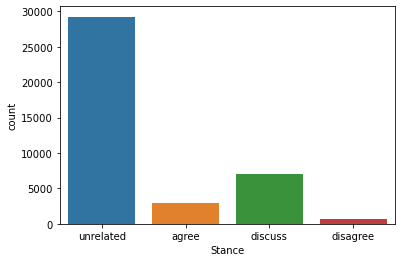

In [15]:
sn.countplot(data=train, x='Stance')
train['Stance'].value_counts()

In [16]:
# Replacing agree, disagree, and discuss with related
def get_relation(y):
    related = {'agree': 1,
               'discuss': 1,
               'disagree': 1,
               'unrelated': 0}
    y = y.replace(related)
    return y

Y_train = get_relation(Y_train)
Y_val = get_relation(Y_val)
Y_test = get_relation(Y_test)

0    29257
1    10720
Name: Stance, dtype: int64

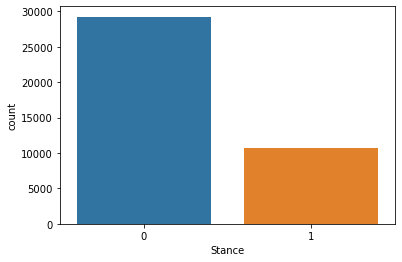

In [17]:
sn.countplot(x=Y_train)
Y_train.value_counts()

In [18]:
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=seed)
X_train, Y_train = rus.fit_resample(X_train, Y_train)
temp_df = X_train
temp_df['Stance'] = Y_train
temp_df = temp_df.sample(frac=1, random_state=seed)
X_train = temp_df.drop(['Stance'], axis=1)
Y_train = temp_df['Stance']

0    10720
1    10720
Name: Stance, dtype: int64

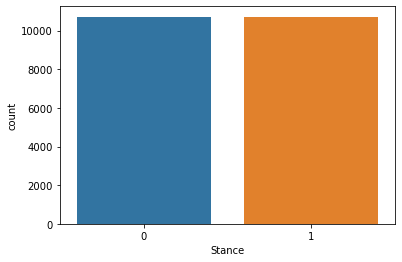

In [19]:
sn.countplot(x=Y_train)
Y_train.value_counts()

### TFIDF vecterisation

In [20]:
# Training tfidf vectoriser
tfidf_vec = pd.concat([X_test['articleBody'], X_train['articleBody']])
tfidf = TfidfVectorizer(decode_error='ignore', lowercase = True, min_df=2, max_features=500)
tfidf.fit(tfidf_vec)

TfidfVectorizer(decode_error='ignore', max_features=500, min_df=2)

In [21]:
dictionary = np.asarray(tfidf.get_feature_names())
print(dictionary[np.random.randint(0,len(dictionary),size=50)])

['sotloff' 'lot' 'security' 'syria' 'star' 'image' 'strike' 'million'
 'film' 'information' 'bear' 'leaders' 'iraqi' 'audio' 'national' 'saw'
 'department' 'said' 'account' 'you' 'hostage' 'added' 'threatened'
 'sotloff' 'authorities' 'local' 'claimed' 'epected' 'beheading' 'penis'
 'bear' 'plans' 'died' 'appeared' 'life' 'it' 'come' 'continue' 'the'
 'journalist' 'path' 'earlier' 'security' 'taken' 'killing' 'youtube'
 'photo' 'going' 'website' 'social']


C:\Users\Ice\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
def stack_tfidf(X):
    header_tfidf = tfidf.transform(X['Headline'].values.astype('U'))
    body_tfidf = tfidf.transform(X['articleBody'].values.astype('U'))
    stacked_tfidf = hstack([header_tfidf, body_tfidf])
    return stacked_tfidf

X_train = stack_tfidf(X_train)
X_val = stack_tfidf(X_val)
X_test = stack_tfidf(X_test)

In [23]:
tfidf_size = X_test.shape
print('tfidf_size:', tfidf_size)

tfidf_size: (25413, 1000)


### preparting the scoring model

In [24]:
# Creating the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

In [25]:
# Creating the ROC Curve
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### a.1.1: TDIF-SVM

In [26]:
# Building the SVM model
parameters = { 
    'C': [1.0, 10],
    'gamma': [1, 'auto']}
model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=3, n_jobs=-1)
model.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1.0, 10], 'gamma': [1, 'auto']})

In [27]:
model.best_params_

{'C': 10, 'gamma': 1}

In [28]:
model = model.best_estimator_

              precision    recall  f1-score   support

           0       0.77      0.95      0.85     18349
           1       0.69      0.28      0.39      7064

    accuracy                           0.76     25413
   macro avg       0.73      0.61      0.62     25413
weighted avg       0.75      0.76      0.73     25413



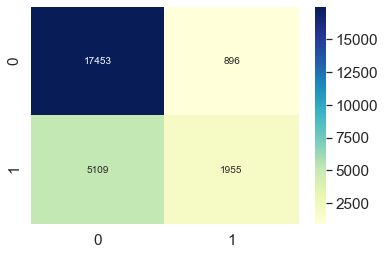

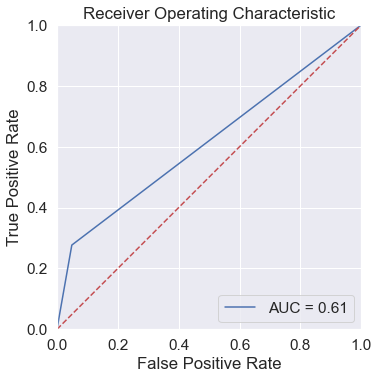

In [29]:
#Predicting the test data
Y_svm = model.predict(X_test)
print(metrics.classification_report(Y_test, Y_svm))
plot_confussion_matrix(Y_test, Y_svm)
plot_roc_curve(Y_test, Y_svm)

### a.2.1: TFIDF-LSTM

In [30]:
def prepare_lstm(X, Y):
    X = X.toarray()
    X = X[:, None, :]
    Y = np.array(Y)
    return X, Y

X_train, Y_train = prepare_lstm(X_train, Y_train)
X_val, Y_val = prepare_lstm(X_val, Y_val)
X_test, Y_test = prepare_lstm(X_test, Y_test)

In [31]:
X_train.shape

(21440, 1, 1000)

In [32]:
Y_train.shape

(21440,)

Epoch 1/5
670/670 [==============================] - 22s 33ms/step - loss: 0.6145 - accuracy: 0.6538 - val_loss: 0.4944 - val_accuracy: 0.7580
Epoch 2/5
670/670 [==============================] - 22s 32ms/step - loss: 0.3900 - accuracy: 0.8169 - val_loss: 0.2854 - val_accuracy: 0.8717
Epoch 3/5
670/670 [==============================] - 22s 32ms/step - loss: 0.2358 - accuracy: 0.8988 - val_loss: 0.2143 - val_accuracy: 0.9083
Epoch 4/5
670/670 [==============================] - 22s 32ms/step - loss: 0.1659 - accuracy: 0.9345 - val_loss: 0.1726 - val_accuracy: 0.9318
Epoch 5/5
670/670 [==============================] - 22s 32ms/step - loss: 0.1240 - accuracy: 0.9530 - val_loss: 0.1474 - val_accuracy: 0.9410


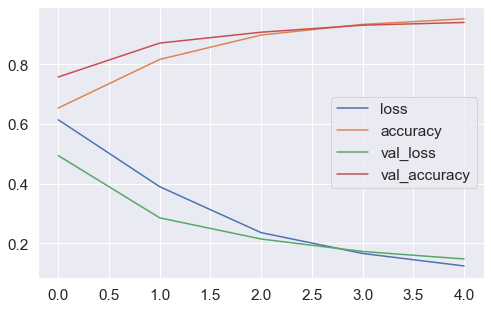

In [33]:
keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model2 = keras.models.Sequential()
model2.add(keras.layers.LSTM(1000,
                            input_shape=(None, 1000),
                            return_sequences=True))
model2.add(keras.layers.Dropout(0.2))
#model2.add(keras.layers.LSTM(1000))
#model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.Dense(1, activation='sigmoid'))
model2.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics = ['accuracy'])
history = model2.fit(X_train, Y_train, 
                    validation_data=(X_val, Y_val),
                    epochs=5, batch_size=32, verbose=1)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

In [34]:
Y_lstm = model2.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


              precision    recall  f1-score   support

           0      0.854     0.588     0.697     18349
           1      0.408     0.738     0.526      7064

    accuracy                          0.630     25413
   macro avg      0.631     0.663     0.611     25413
weighted avg      0.730     0.630     0.649     25413



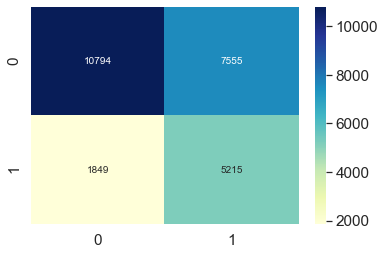

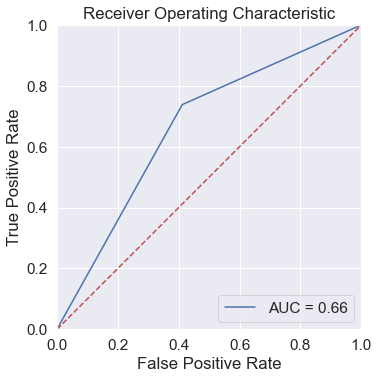

In [35]:
print(metrics.classification_report(Y_test, Y_lstm.reshape(len(Y_lstm)), digits=3))
plot_confussion_matrix(Y_test, Y_lstm.reshape(len(Y_lstm)))
plot_roc_curve(Y_test, Y_lstm.reshape(len(Y_lstm)))

### a.1.2: Bert-SVM